# GENERATION OF SEVERAL SUPPLEMENTARY TABLES + CLEANED-UP SOURCE DATA

load modules:

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import sys
import os

sys.path.append("../../scripts/")
import reference_based_harmonizing
import utils

In [2]:
%load_ext lab_black

set paths:

In [3]:
path_hlca_core = "../../data/HLCA_core_h5ads/HLCA_v2.h5ad"
path_hlca_core_clean_out = (
    "../../data/HLCA_core_h5ads/clean_objects_to_share/HLCA_core_v1.1_to_share.h5ad"
)
path_hlca_ext_emb = (
    "../../data/HLCA_extended/HLCA_extended/HLCA_extended_full_object.h5ad"
)
path_hlca_ext_clean_out = (
    "../../data/HLCA_extended/clean_objects_to_share/HLCA_full_v1.1_to_share.h5ad"
)
path_cell_label_harmonization = "../../supporting_files/metadata_harmonization/HLCA_cell_type_reference_mapping_20221007.csv"
path_manual_anns_in = "../../supporting_files/celltype_structure_and_colors/manual_anns_and_leveled_anns_ordered.csv"
dir_cov_mod_results_in = "../../results/covariate_modeling/output/"
dir_supp_tables_out = "../../results/suppl_tables/"

load data:

In [5]:
core = sc.read_h5ad(path_hlca_core)

In [4]:
ext = sc.read_h5ad(path_hlca_ext_emb)

## DATASET TABLE: 

creates part of the dataset info from supplementary table

In [6]:
def get_set_as_str(x):
    """Function to extract string of the set of values from a dataframe column"""
    x_set = x.unique()
    x_set_str_list = [str(i) for i in x_set]
    x_set_str = ", ".join(x_set_str_list)
    return x_set_str

In [7]:
dataset_overview = ext.obs.groupby("study").agg(
    n_datasets=("dataset", "nunique"),
    dataset_names=("dataset", get_set_as_str),
    core_or_extension=("core_or_extension", get_set_as_str),
    lung_condition=("condition", get_set_as_str),
    n_subjects=("subject_ID", "nunique"),
    n_samples=("sample", "nunique"),
    n_cells=("study", "count"),
    cells_or_nuclei=("cells_or_nuclei", get_set_as_str),
    single_cell_platform=("single_cell_platform", get_set_as_str),
    tissue_sampling_type=("sample_type", get_set_as_str),
)

In [8]:
dataset_overview["in_core"] = [
    "core" in c_or_e for c_or_e in dataset_overview.core_or_extension
]

In [9]:
dataset_overview.sort_values(
    by=["in_core", "study"], ascending=[False, True], inplace=True
)

## SAMPLE TABLE

In [10]:
sample_overview = (
    ext.obs.groupby("sample")
    .agg(
        HLCA_core_or_extension=("core_or_extension", "first"),
        dataset=("dataset", "first"),
        study=("study", "first"),
        n_cells=("sample", "count"),
        subject_ID=("subject_ID", "first"),
        age=("age", "first"),
        sex=("sex", "first"),
        lung_condition=("condition", "first"),
        cells_or_nuclei=("cells_or_nuclei", "first"),
        single_cell_platform=("single_cell_platform", "first"),
        tissue_sampling_type=("sample_type", "first"),
        tissue_dissociation_protocol=("tissue_dissociation_protocol", "first"),
        ancestry=("ancestry", "first"),
        mixed_ancestry=("mixed_ancestry", "first"),
        smoking_status=("smoking_status", "first"),
        BMI=("BMI", "first"),
        cause_of_death=("cause_of_death", "first"),
        sequencing_platform=("sequencing_platform", "first"),
        cell_ranger_version=("cell_ranger_version", "first"),
        fresh_or_frozen=("fresh_or_frozen", "first"),
        anatomical_region_level_1=("anatomical_region_level_1", "first"),
        anatomical_region_level_2=("anatomical_region_level_2", "first"),
        anatomical_region_level_3=("anatomical_region_level_3", "first"),
    )
    .sort_values(by=["HLCA_core_or_extension", "study", "dataset", "subject_ID"])
)

sanity check: check if any sample has multiple values for any of these covariates (should not be the case):

In [11]:
agg_style = "nunique"
sample_unique_covs = ext.obs.groupby("sample").agg(
    {
        var: agg_style
        for var in [
            "core_or_extension",
            "dataset",
            "study",
            "sample",
            "subject_ID",
            "age",
            "sex",
            "condition",
            "cells_or_nuclei",
            "single_cell_platform",
            "sample_type",
            "tissue_dissociation_protocol",
            "ancestry",
            "mixed_ancestry",
            "smoking_status",
            "BMI",
            "cause_of_death",
            "sequencing_platform",
            "cell_ranger_version",
            "fresh_or_frozen",
            "anatomical_region_level_1",
            "anatomical_region_level_2",
            "anatomical_region_level_3",
        ]
    }
)

This should be 0:

In [12]:
(sample_unique_covs > 1).sum().sum()

0

for anatomical region, remove forward-propagated labels:

In [13]:
for lev in range(1, 4):
    cov = f"anatomical_region_level_{lev}"
    mapping = {loc: loc for loc in sample_overview[cov].unique()}
    for key, value in mapping.items():
        if not pd.isnull(key):
            if key[:2] in ["1_", "2_"]:
                mapping[key] = np.nan
    sample_overview[cov] = sample_overview[cov].map(mapping)

put "v" before cell ranger version, to prevent conversion to dates in excel:

In [14]:
cell_ranger_cleaner = {
    v: f"v.{v}" for v in sample_overview.cell_ranger_version.unique()
}
cell_ranger_cleaner["nan"] = "nan"
sample_overview.cell_ranger_version = sample_overview.cell_ranger_version.map(
    cell_ranger_cleaner
)

## Cell type reference mapping:

In [15]:
harmonizing_df = reference_based_harmonizing.load_harmonizing_table(
    path_cell_label_harmonization
)
# consensus_df = reference_based_harmonizing.create_consensus_table(harmonizing_df)

remove columns after first "unnamed" column:

In [16]:
last_column = np.where(harmonizing_df.columns.str.startswith("Unnamed"))[0][0]

In [17]:
harmonizing_df = harmonizing_df.iloc[:, :last_column]

In [18]:
harmonizing_df.dropna(axis=0, how="all", inplace=True)
harmonizing_df.dropna(axis=1, how="all", inplace=True)

In [19]:
harmonizing_df

,Level_1,Level_2,Level_3,Level_4,Level_5,Banovich_Kropski_2020,Barbry_Leroy_2020,Jain_Misharin_2021,Krasnow_2020,Meyer_2019,...,Seibold_2020,Teichmann_Meyer_2019,Thienpont_2018,Kaminski_2020,Banovich_Kropski_2020_disease,Misharin_Budinger_2018_disease,Eils_2020,Sheppard_2020,Duong_lungMAP_unpubl,Sun_2020
0,Epithelial,None,None,None,None,None,None,None,None,None,...,None,None,Epithelial,None,Proliferating Epithelial Cells,Proliferating epithelial,None,Epithelial,None,None
1,None,Airway epithelium,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,None,None,Basal,None,None,Basal,None,None,Basal,None,...,None,None,None,Basal,Basal,KRT5 Basal cells,None,None,Basal,basal cells
3,None,None,Basal,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,None,None,Basal,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,Proliferating cells,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
283,Unknown,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,Mast/Basal,unclassified
284,Cancer,None,None,None,None,None,None,None,None,None,...,None,None,Cancer,None,None,None,None,None,None,None
285,Unicorns and artifacts,None,None,None,None,AT2 - low quality,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


## Manual annotations, hierarchy:

In [15]:
manual_ann_hierarchy = pd.read_csv(path_manual_anns_in, index_col=0)

In [16]:
manual_ann_hierarchy.drop(columns=["ordering", "colors"], inplace=True)

In [17]:
manual_ann_hierarchy.columns = [
    f"Level {lev} annotation (n cells, % of cells)" for lev in range(1, 6)
]

In [18]:
ct_perc_per_lev = dict()
ct_n_per_lev = dict()
for lev in range(1, 6):
    ct_n = core.obs[f"ann_level_{lev}"].value_counts()
    ct_perc = round(ct_n / core.n_obs * 100, 1)
    ct_perc_per_lev[lev] = ct_perc
    ct_n_per_lev[lev] = ct_n
ct_n_per_lev["finest"] = core.obs.manual_ann.value_counts()
ct_perc_per_lev["finest"] = round(
    core.obs.manual_ann.value_counts() / core.n_obs * 100, 1
)

In [21]:
new_index = list()
for ct in manual_ann_hierarchy.index:
    new_index.append(
        f"{ct} (n={ct_n_per_lev['finest'][ct]}, {ct_perc_per_lev['finest'][ct]}%)"
    )
manual_ann_hierarchy.index = new_index

In [22]:
for lev in range(1, 6):
    new_values_uncleaned = [
        f"{ct} (n={ct_n_per_lev[lev][ct]}, {ct_perc_per_lev[lev][ct]}%)"
        for ct in manual_ann_hierarchy[f"Level {lev} annotation (n cells, % of cells)"]
    ]
    new_values = list()
    for ct in new_values_uncleaned:
        if ct[:2] in ["1_", "2_", "3_", "4_"]:
            new_values.append(np.nan)
        else:
            new_values.append(ct)
    manual_ann_hierarchy[f"Level {lev} annotation (n cells, % of cells)"] = new_values

In [24]:
manual_ann_hierarchy.index.name = "Finest annotation (n cells, % of cells)"

In [25]:
manual_ann_hierarchy

,"Level 1 annotation (n cells, % of cells)","Level 2 annotation (n cells, % of cells)","Level 3 annotation (n cells, % of cells)","Level 4 annotation (n cells, % of cells)","Level 5 annotation (n cells, % of cells)"
"Finest annotation (n cells, % of cells)",,,,,
"Basal resting (n=38955, 6.7%)","Epithelial (n=282065, 48.2%)","Airway epithelium (n=207023, 35.4%)","Basal (n=84713, 14.5%)","Basal resting (n=38955, 6.7%)",NaN
"Suprabasal (n=41158, 7.0%)","Epithelial (n=282065, 48.2%)","Airway epithelium (n=207023, 35.4%)","Basal (n=84713, 14.5%)","Suprabasal (n=41158, 7.0%)",NaN
"Hillock-like (n=4600, 0.8%)","Epithelial (n=282065, 48.2%)","Airway epithelium (n=207023, 35.4%)","Basal (n=84713, 14.5%)","Hillock-like (n=4600, 0.8%)",NaN
"Deuterosomal (n=1004, 0.2%)","Epithelial (n=282065, 48.2%)","Airway epithelium (n=207023, 35.4%)","Multiciliated lineage (n=41098, 7.0%)","Deuterosomal (n=1004, 0.2%)",NaN
"Multiciliated (nasal) (n=4869, 0.8%)","Epithelial (n=282065, 48.2%)","Airway epithelium (n=207023, 35.4%)","Multiciliated lineage (n=41098, 7.0%)","Multiciliated (n=40094, 6.9%)","Multiciliated (nasal) (n=4869, 0.8%)"
...,...,...,...,...,...
"Monocyte-derived Mph (n=28223, 4.8%)","Immune (n=229496, 39.2%)","Myeloid (n=155315, 26.6%)","Macrophages (n=111844, 19.1%)","Interstitial macrophages (n=33028, 5.6%)","Monocyte-derived Mph (n=28223, 4.8%)"
"Interstitial Mph perivascular (n=4805, 0.8%)","Immune (n=229496, 39.2%)","Myeloid (n=155315, 26.6%)","Macrophages (n=111844, 19.1%)","Interstitial macrophages (n=33028, 5.6%)","Interstitial Mph perivascular (n=4805, 0.8%)"
"Classical monocytes (n=17695, 3.0%)","Immune (n=229496, 39.2%)","Myeloid (n=155315, 26.6%)","Monocytes (n=26529, 4.5%)","Classical monocytes (n=17695, 3.0%)",NaN


## Covariate modeling, gene results:

Here we are just renaming the files and storing them in the SuppT folder

In [28]:
# cts = os.listdir(dir_cov_mod_results_in)

In [29]:
# ct_results_gene = dict()

In [30]:
# for ct in cts:
#     ct_results_gene[ct] = pd.read_csv(
#         os.path.join(dir_cov_mod_results_in, ct, "mm_output_padj.csv"), index_col=0
#     )

## "Source data": the HLCA core

prepare:

In [31]:
obs_cols_to_keep = [
    "BMI",
    "age",
    "anatomical_region_ccf_score",
    "anatomical_region_level_1",
    "anatomical_region_level_2",
    "anatomical_region_level_3",
    "ancestry",
    "ann_level_1_clean",
    "ann_level_2_clean",
    "ann_level_3_clean",
    "ann_level_4_clean",
    "ann_level_5_clean",
    "cause_of_death",
    "condition",
    "dataset",
    "entropy_dataset_leiden_3",
    "entropy_original_ann_level_1_leiden_3",
    "entropy_original_ann_level_2_clean_leiden_3",
    "entropy_original_ann_level_3_clean_leiden_3",
    "entropy_subject_ID_leiden_3",
    "fresh_or_frozen",
    "leiden_1",
    "leiden_2",
    "leiden_3",
    "leiden_4",
    "leiden_5",
    "log10_total_counts",
    "manual_ann",
    "manual_ann_grouped",
    "mixed_ancestry",
    "n_genes_detected",
    "original_ann_highest_res",
    "original_ann_level_1_clean",
    "original_ann_level_2_clean",
    "original_ann_level_3_clean",
    "original_ann_level_4_clean",
    "original_ann_level_5_clean",
    "original_celltype_ann",
    "reannotation_type",
    "sample",
    "sample_type",
    "scanvi_label",
    "sequencing_platform",
    "sex",
    "single_cell_platform",
    "size_factors",
    "smoking_status",
    "study",
    "subject_ID",
    "subject_type",
    "tissue_dissociation_protocol",
]

In [32]:
var_cols_to_keep = ["gene_ids"]

In [33]:
obs_renaming = {
    "original_ann_level_1_clean": "original_ann_level_1",
    "original_ann_level_2_clean": "original_ann_level_2",
    "original_ann_level_3_clean": "original_ann_level_3",
    "original_ann_level_4_clean": "original_ann_level_4",
    "original_ann_level_5_clean": "original_ann_level_5",
    "ann_level_1_clean": "ann_level_1",
    "ann_level_2_clean": "ann_level_2",
    "ann_level_3_clean": "ann_level_3",
    "ann_level_4_clean": "ann_level_4",
    "ann_level_5_clean": "ann_level_5",
    "manual_ann": "ann_finest_level",
    "manual_ann_grouped": "ann_coarse_for_GWAS_and_modeling",
    "original_celltype_ann": "original_ann_nonharmonized",
    "condition": "lung_condition",
    "sample_type": "tissue_sampling_method",
}

In [34]:
uns_to_keep = [
    "manual_ann_colors",
    "manual_ann_grouped_colors",
    "neighbors",
    "umap",
]

In [35]:
uns_to_rename = {
    "manual_ann_colors": "ann_finest_level_colors",
    "manual_ann_grouped_colors": "ann_coarse_for_GWAS_and_modeling_colors",
}

Now clean:

In [36]:
for obsm_cat in ["X_pca", "X_umap_scanvi", "X_umap_unintegrated"]:
    if obsm_cat in core.obsm.keys():
        del core.obsm[obsm_cat]

In [37]:
del core.varm

In [38]:
core.obs = core.obs.loc[:, obs_cols_to_keep].copy()
core.var = core.var.loc[:, var_cols_to_keep].copy()

In [39]:
core.obs.rename(columns=obs_renaming, inplace=True)

In [40]:
uns_keys = list(core.uns.keys())
for uns in uns_keys:
    if uns not in uns_to_keep:
        del core.uns[uns]
# rename
for orig_name, new_name in uns_to_rename.items():
    core.uns[new_name] = core.uns[orig_name]
    del core.uns[orig_name]

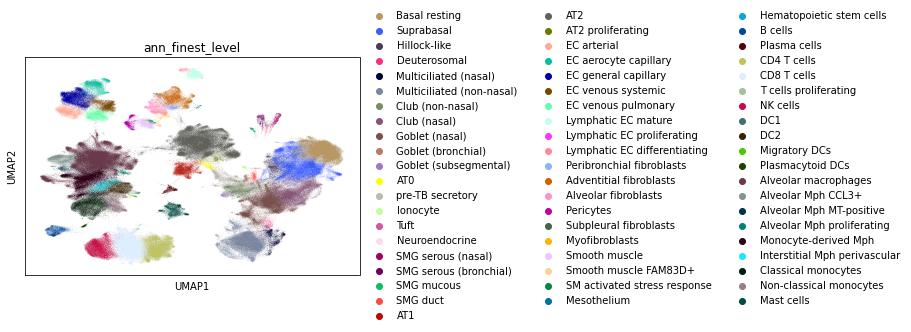

In [41]:
sc.pl.umap(core, color="ann_finest_level")

convert adata.X to float32:

In [42]:
core.X = core.X.astype(np.float32)

Set all versions of nan (i.e. "nan", NaN, None, etc.) to np.nan:

In [43]:
core_obs_none_entries = core.obs.applymap(utils.check_if_nan)
core.obs.mask(core_obs_none_entries.values, inplace=True)

and store:

In [44]:
core.write(
    path_hlca_core_clean_out,
    compression="gzip",
)

## "Source data": HLCA extension

In [6]:
ext

AnnData object with n_obs × n_vars = 2382658 × 59574
    obs: 'sample', 'original_celltype_ann', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'subject_ID_as_published', 'pre_or_postnatal', 'age_in_years', 'age_range', 'sex', 'smoking_status', 'smoking_history', 'BMI', 'known_lung_disease', 'condition', 'subject_type', 'cause_of_death', 'sample_type', 'anatomical_region_coarse', 'anatomical_region_detailed', 'tissue_dissociation_protocol', 'cells_or_nuclei', 'single_cell_platform', "3'_or_5'", 'enrichment', 'sequencing_platform', 'reference_genome_coarse', 'ensembl_release_reference_genome', 'cell_ranger_version', 'disease_status', 'fresh_or_frozen', 'cultured', 'cell_viability_%', 'comments', 'Processing_site', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'n_genes', 'total_counts',

In [9]:
import matplotlib.pyplot as plt

In [13]:
ext.layers["raw"][-10:, -10:].toarray()

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.94607663, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

In [5]:
ext_obs_cols_to_keep = [
    "BMI",
    "age",
    "anatomical_region_ccf_score",
    "anatomical_region_coarse",
    "anatomical_region_detailed",
    "anatomical_region_level_1",
    "anatomical_region_level_2",
    "anatomical_region_level_3",
    "ancestry",
    "ann_level_1_clean",
    "ann_level_2_clean",
    "ann_level_3_clean",
    "ann_level_4_clean",
    "ann_level_5_clean",
    "cause_of_death",
    "cells_or_nuclei",
    "condition",
    "core_or_extension",
    "dataset",
    "fresh_or_frozen",
    # 'log10_total_counts', # add when we have the full counts matrix
    "manual_ann",
    "manual_ann_grouped",
    "mixed_ancestry",
    # 'n_genes_detected', # add when we have the full counts matrix
    "original_ann_level_1_clean",
    "original_ann_level_2_clean",
    "original_ann_level_3_clean",
    "original_ann_level_4_clean",
    "original_ann_level_5_clean",
    "original_celltype_ann",
    "reannotation_type",
    "sample",
    "sample_type",
    "scanvi_label",
    "sequencing_platform",
    "sex",
    "single_cell_platform",
    # 'size_factors', # add when we have a SCRAN-normalized full counts matrix
    "smoking_status",
    "study",
    "subject_ID",
    "subject_type",
    "tissue_dissociation_protocol",
    "transf_ann_level_1_label",
    "transf_ann_level_1_uncert",
    "transf_ann_level_2_label",
    "transf_ann_level_2_uncert",
    "transf_ann_level_3_label",
    "transf_ann_level_3_uncert",
    "transf_ann_level_4_label",
    "transf_ann_level_4_uncert",
    "transf_ann_level_5_label",
    "transf_ann_level_5_uncert",
]

In [46]:
ext_uns_to_keep = [
    "neighbors",
    "umap",
]

In [9]:
ext

AnnData object with n_obs × n_vars = 2382658 × 61928
    obs: 'sample', 'original_celltype_ann', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'subject_ID_as_published', 'pre_or_postnatal', 'age_in_years', 'age_range', 'sex', 'smoking_status', 'smoking_history', 'BMI', 'known_lung_disease', 'condition', 'subject_type', 'cause_of_death', 'sample_type', 'anatomical_region_coarse', 'anatomical_region_detailed', 'tissue_dissociation_protocol', 'cells_or_nuclei', 'single_cell_platform', "3'_or_5'", 'enrichment', 'sequencing_platform', 'reference_genome_coarse', 'ensembl_release_reference_genome', 'cell_ranger_version', 'disease_status', 'fresh_or_frozen', 'cultured', 'cell_viability_%', 'comments', 'Processing_site', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'n_genes', 'total_counts',

In [10]:
unc_threshold = 0.2

In [11]:
# column renaming info
col_renamer_ext = {
    "original_ann_level_1_clean": "original_ann_level_1",
    "original_ann_level_2_clean": "original_ann_level_2",
    "original_ann_level_3_clean": "original_ann_level_3",
    "original_ann_level_4_clean": "original_ann_level_4",
    "original_ann_level_5_clean": "original_ann_level_5",
    "ann_level_1_clean": "ann_level_1",
    "ann_level_2_clean": "ann_level_2",
    "ann_level_3_clean": "ann_level_3",
    "ann_level_4_clean": "ann_level_4",
    "ann_level_5_clean": "ann_level_5",
    "manual_ann": "ann_finest_level",
    "manual_ann_grouped": "ann_coarse_for_GWAS_and_modeling",
    "original_celltype_ann": "original_ann_nonharmonized",
    "condition": "lung_condition",
    "sample_type": "tissue_sampling_method",
}
for lev in range(1, 6):
    col_renamer_ext[
        "anatomical_region_coarse"
    ] = "anatomical_region_coarse_unharmonized"
    col_renamer_ext[
        "anatomical_region_detailed"
    ] = "anatomical_region_detailed_unharmonized"
    col_renamer_ext[f"original_ann_level_{lev}_clean"] = f"original_ann_level_{lev}"

Now clean:

In [12]:
ext.obs = ext.obs.loc[:, ext_obs_cols_to_keep].copy()

In [13]:
ext_uns_keys = list(ext.uns.keys())
for uns in ext_uns_keys:
    if uns not in ext_uns_to_keep:
        del ext.uns[uns]

Add scanvi embedding to obsm:

In [51]:
# do this once we have the full gene matrix

rename obs columns:

In [14]:
ext.obs.rename(columns=col_renamer_ext, inplace=True)

add column with threshold:

In [15]:
for lev in range(1, 6):
    ext.obs[f"transf_ann_level_{lev}_label_thresholded"] = ext.obs[
        f"transf_ann_level_{lev}_label"
    ].tolist()
    ext.obs.loc[
        ext.obs[f"transf_ann_level_{lev}_uncert"] > unc_threshold,
        f"transf_ann_level_{lev}_label_thresholded",
    ] = "Unknown"

add transfered labels to "ann_level_[1-5]" plus to ann_finest_level, so that annotations of core and extension can be visualized and analyzed at once

In [16]:
for lev in range(1, 6):
    ext.obs[f"ann_level_{lev}"] = ext.obs[
        f"ann_level_{lev}"
    ].tolist()  # so that we can freely add new categories
    ext.obs.loc[ext.obs.core_or_extension == "extension", f"ann_level_{lev}"] = [
        transf_ann
        for transf_ann, core_or_ext in zip(
            ext.obs[f"transf_ann_level_{lev}_label_thresholded"],
            ext.obs.core_or_extension,
        )
        if core_or_ext == "extension"
    ]
    # remove annotations with prefixes:
    ext.obs.loc[ext.obs.core_or_extension == "extension", f"ann_level_{lev}"] = [
        np.nan if lab[1] == "_" else lab
        for lab, core_or_ext in zip(
            ext.obs[f"ann_level_{lev}"], ext.obs.core_or_extension
        )
        if core_or_ext == "extension"
    ]
# for ann finest level:
ext.obs.ann_finest_level = (
    ext.obs.ann_finest_level.tolist()
)  # so that we can freely add new categories
# add transfered anns from level 5
ext.obs.loc[ext.obs.core_or_extension == "extension", "ann_finest_level"] = [
    transf_ann
    for transf_ann, core_or_ext in zip(
        ext.obs["transf_ann_level_5_label_thresholded"],
        ext.obs.core_or_extension,
    )
    if core_or_ext == "extension"
]
# remove prefixes from annotations
ext.obs.loc[ext.obs.core_or_extension == "extension", "ann_finest_level"] = [
    lab[2:] if lab[1] == "_" else lab
    for lab, core_or_ext in zip(ext.obs.ann_finest_level, ext.obs.core_or_extension)
    if core_or_ext == "extension"
]

In [17]:
sc.set_figure_params(figsize=(8, 8))

In [56]:
## as check:
# sc.pl.umap(ext, color=["ann_level_2", "ann_finest_level"], ncols=1, frameon=False)

remove thresholded transfered annotations (those are now in ann_level_[1-5])

In [18]:
for lev in range(1, 6):
    del ext.obs[f"transf_ann_level_{lev}_label_thresholded"]

sort columns alphabetically:

In [19]:
ext.obs = ext.obs.loc[:, sorted(ext.obs.columns)].copy()

In [20]:
ext

AnnData object with n_obs × n_vars = 2382658 × 61928
    obs: 'BMI', 'age', 'anatomical_region_ccf_score', 'anatomical_region_coarse_unharmonized', 'anatomical_region_detailed_unharmonized', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'ancestry', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'cells_or_nuclei', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'sex', 'single_cell_platform', 'smoking_status', 'study', 'subject_ID', 'subject_type', 'tissue_dissociation_protocol', 'tissue_sampling_method', 'transf_ann_level_1_label', 'transf_ann_level_1_uncert', 'transf_ann_level_2_label', 'tra

Convert float64 to float32 for counts (both raw and normalized):

In [60]:
ext.X = ext.X.astype(np.float32)
# to add: same for layer['counts']

Set all versions of nan (i.e. "nan", NaN, None, etc.) to np.nan:

In [61]:
ext_obs_none_entries = ext.obs.applymap(utils.check_if_nan)
ext.obs.mask(ext_obs_none_entries.values, inplace=True)

Write:

In [62]:
ext.write(path_hlca_ext_clean_out, compression="gzip")

## Store tables:

In [63]:
dataset_overview.to_csv(
    os.path.join(dir_supp_tables_out, "SuppT_1_dataset_overview.csv")
)

In [64]:
sample_overview.to_csv(os.path.join(dir_supp_tables_out, "SuppT_2_sample_overview.csv"))

In [26]:
manual_ann_hierarchy.to_csv(os.path.join(dir_supp_tables_out, "SuppT_5_manual_ann.csv"))

In [66]:
harmonizing_df.to_csv(
    os.path.join(dir_supp_tables_out, "SuppT_4_celltype_ref_mapping.csv")
)

In [68]:
# for ct, ct_res in ct_results_gene.items():
#     ct_res.to_csv(
#         os.path.join(
#             dir_supp_tables_out, "SuppT_X_covariate_modeling_gene_results", ct + ".csv"
#         )
#     )